In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from hamiltonian.hamiltonian import get_hamiltonian
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'

In [2]:
def calc_classical_bound(theta, H, N, m, basis, extra_Z_gate):

    # Obtaining the general correlation matrix
    M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=extra_Z_gate)

    # Adding one to number of measurements to account for the extra z_gate
    if extra_Z_gate:
        m += 1

    # Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
    Bell_terms, indices = get_Bell_terms(M, N, m)

    # Calculating the coefficients
    coeffs = get_coefficients(Bell_terms, H, N)

    # Calculating and returning the classical bound 
    return classical_optimization(coeffs, indices, N, m)


def callback_function(theta):

    # Calculating and returning the classical bound 
    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )

In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
import numba as nb

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from hamiltonian.hamiltonian import get_hamiltonian
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from classical_optimization.classical_bound import calc_classical_bound
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'

In [2]:
# Defining qubit transform
qubit_transform = 'BK'

# Obtainig Hamiltonian
hamiltonian = get_hamiltonian(qubit_transform = qubit_transform)

# Extracting parameters
H = hamiltonian.matrix_form
N = hamiltonian.N

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# Extracting the ground state energy and the respective eigenstate
E_G = eig_vals[0]
psi_G = eig_vecs[:,0]
psi_G_dagger = np.conjugate(np.transpose(psi_G))


In [3]:
# Defining small error
eps = 1e-3

# Defining number of measurements and the angle between the two parties
m = 2
# theta = np.random.rand(N*m-1)*(np.pi-2*eps)+eps
theta = [np.pi/2, 0, np.pi/2, 0, np.pi/2, 0, np.pi/2]

# # Initializing basis and extra Z gate
basis = 'XY'
extra_Z_gate = True

# # Obtaining the general correlation matrix
M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=True)

# # Adding one to number of measurements to account for the extra z_gate
if extra_Z_gate:
    m += 1

# Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
Bell_terms, indices = get_Bell_terms(M, N, m)

# Calculating the coefficients
coeffs = get_coefficients(Bell_terms, H, N)

# Obtaining all possible configurations of the correlation matrix
possible_configurations = nb.typed.List( 
    list(itertools.product([1, -1], repeat=m*N)) 
)

# Calculating the classical bound
beta_C = classical_optimization(coeffs, nb.typed.List(indices), possible_configurations, N, m)
beta_C


In [7]:
A = nb.typed.List([])
A.append(3)
A[0]

3

In [9]:
C = nb.typed.List( [nb.types.int64(1)]*3 )
q = nb.types.int64(1)
for j in range(3):
    q *= C[j]
A.append( q )


In [5]:
# Initializing the Bell operator
B = np.zeros((2**N, 2**N), dtype='complex128')

# Adding terms to the Bell operator
for j in range(len(coeffs)):
    B += coeffs[j] * Bell_terms[j]

# Calculating the difference between the Bell operator and the Hamiltonian
# print(np.sum(np.abs(B-H), axis=(0,1)))

# Calculting the quantum value
beta_Q = np.matmul(psi_G_dagger, np.matmul(B, psi_G))
np.real(beta_Q)

-1.8510456784448648

In [35]:
# Defining the number of measurements
m = 2

# Initializing empty list beta_C for call_back function
beta_C = []

# Defining angles
eps = 1e-2
init_guess = np.random.rand(N*m-1)*(np.pi-2*eps)+eps

# Defining arguments
basis = 'XY'
extra_Z_gate = True
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
}

# Defining a fitting function and a callback function
def fitting_func(theta, H, N, m, basis, extra_Z_gate):

    return -calc_classical_bound(theta, H, N, m, basis, extra_Z_gate)

def callback_function(theta):

    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )


# Defining the minimizer keyword arguments
minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                'options' : options,
                'callback': callback_function
}

res = basinhopping(fitting_func, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 2,
                disp = True
)

res

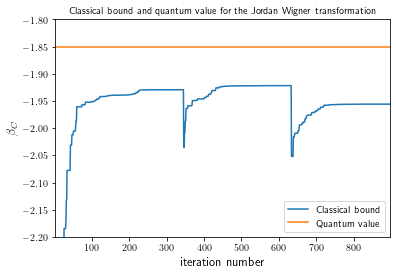

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), beta_C, label=r'Classical bound')
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), np.real(beta_Q)*np.ones(len(beta_C)), label=r'Quantum value')
ax.set_xlabel(r'iteration number')
ax.set_ylabel(r'$\beta_C$')
ax.set_ylim((-2.2, -1.8))
ax.set_xlim((1, len(beta_C)))
ax.legend()
if qubit_transform == 'JW':
    ax.set_title(r'Classical bound and quantum value for the Jordan Wigner transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Jordan_Wigner_m_%0f.png' %(m), dpi = 300, bbox_inches='tight');
elif qubit_transform == 'BK':
    ax.set_title(r'Classical bound and quantum value for the Bravyi-Kitaev transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Bravyi_Kitaev_m_%0f.png' %(m), dpi = 300, bbox_inches='tight');